# Bayesian Baseline Model for Rossmann Sales Forecasting

## Overview

This notebook implements a **Bayesian hierarchical model** to establish a baseline for Rossmann store sales. The baseline represents expected sales in the absence of promotional activities, allowing us to measure the incremental lift from promotions and construct a robust Marketing Mix Model (MMM).

## Goal
1. **Fit Baseline**: Model log-sales using ONLY non-promotional drivers (seasonality, trends, holidays, competition).
2. **Counterfactual Prediction**: Predict sales for historical periods assuming `Promo=0` and `Promo2=0`.
3. **Lift Calculation**: Compute empirical lift by comparing actual sales to the counterfactual baseline.
4. **Discount Intensity**: Derive a hybrid discount intensity metric to serve as a strong predictor in downstream MMMs.

## Methodology
We use **PyMC** for probabilistic programming.
- **Hierarchical Store Effects**: Partial pooling with non-centered parameterization to handle data from 1,115 stores efficiently.
- **Gaussian Random Walk**: Captures latent, dynamic time trends (macroeconomic factors, brand equity changes) that are not explained by fixed covariates.
- **Sum-to-Zero Constraints**: Applied to day-of-week and month seasonality to ensure model identifiability.

---

In [1]:
import numpy as np
import pandas as pd
import os
os.environ["PYTENSOR_FLAGS_CXX"] = "g++"
# Prevent the buggy optimization rewrite
os.environ["PYTENSOR_FLAGS"] = "optimizer_excluding=local_subtensor_merge"
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle
import json
import bayesian_utils as bbu  # Custom documented utility module

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"PyMC version: {pm.__version__}")
print(f"ArviZ version: {az.__version__}")

Bayesian module loaded successfully!
PyMC version: 5.27.0
ArviZ version: 0.23.0


## 1. Data Loading

We load the standard Rossmann `train.csv` and `store.csv` datasets. 
Note: Ensure the paths point to your local data directory.

In [2]:
# Load data
train_df = pd.read_csv(r"data\train.csv", low_memory=False)
store_df = pd.read_csv(r"data\store.csv")

# Merge store attributes
df_full = train_df.merge(store_df, on="Store", how="left")
print(f"Total observations: {len(df_full):,}")

Total observations: 1,017,209


## 2. Data Preparation

We use `prepare_rossmann_baseline_df` to clean and feature-engineer the data for the Bayesian model.

**Key Steps:**
- **Filter**: Only open stores with non-negative sales.
- **Target**: Log-transform sales: $y = \log(\text{Sales} + 1)$.
- **Indexing**: Create contiguous integer indices (0..N-1) for Stores, Time, Day-of-Week, and Month to map them to model parameters.
- **Categoricals**: Convert StateHoliday to binary; handle CompetitionDistance.

See `help(bbu.prepare_rossmann_baseline_df)` for full details.

In [3]:
# Prepare data frame
# For faster prototyping, use a subset of data
subset_stores = df_full['Store'].unique()[:100]  # First n stores
df_subset = df_full[df_full['Store'].isin(subset_stores)].copy()
df_model, S, T = bbu.prepare_rossmann_baseline_df(df_subset)

print(f"\nPrepared data for {S} stores and {T} time points.")
df_model.head()

Before filtering: 91,256 observations
After filtering (Open=1, Sales>=0): 75,597 observations
Time points (T): 942
Number of stores (S): 100

Prepared data for 100 stores and 942 time points.


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,y,t_idx,store_idx,dow_idx,month_idx,state_holiday,school_holiday,log_comp_dist
1016179,85,2,2013-01-01,4220,619,1,0,a,1,b,...,NaN,NaN,8.347827,0,84,1,0,1,1,7.534228
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,...,NaN,NaN,8.618124,1,0,2,0,0,1,7.147559
1014981,2,3,2013-01-02,4422,650,1,0,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",8.394573,1,1,2,0,0,1,6.347389
1014982,3,3,2013-01-02,6823,805,1,0,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",8.828201,1,2,2,0,0,1,9.556126
1014983,4,3,2013-01-02,9941,1429,1,0,0,1,c,...,NaN,NaN,9.204523,1,3,2,0,0,1,6.431331


## 3. Build Model Arrays

PyMC requires numeric arrays (often `float32` or `int64`) rather than pandas Series. We extract these using `build_baseline_arrays`.

**Important**: We use `int64` for indices to avoid overflow errors in Pytensor graph compilation when dealing with >1000 stores.

In [4]:
# Extract arrays
y, store_idx, t_idx, dow_idx, month_idx, state_h, school_h, log_comp = bbu.build_baseline_arrays(df_model)

## 4. Bayesian Baseline Model Fitting

We fit the hierarchical model.
- **No Promo**: Note that `Promo` and `Promo2` are arguably the strongest drivers of sales, but they are *excluded* here. This forces the model to learn the "natural" baseline sales.

Sampling may take some time depending on your hardware (GPU relies on specific Pytensor config).

In [5]:
# Fit the model
model, idata = bbu.fit_bayesian_baseline(
    y, store_idx, t_idx, dow_idx, month_idx, state_h, school_h, log_comp,
    S=S, T=T,
    draws=1000, tune=1000, chains=2, target_accept=0.9
)

Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
c:\Users\SolaiVenkatesanManog\projects\kaggle\MMM\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_store, store_offset, alpha, dow_raw, mon_raw, beta_state_h, beta_school_h, beta_comp, sigma_level, level, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5035 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Model Diagnostics
Check for convergence using `r_hat` (should be < 1.01) and trace plots.

In [11]:
# Summary statistics
summary = az.summary(
    idata,
    var_names=["alpha", "tau_store", "beta_state_h", "beta_school_h", 
               "beta_comp", "sigma_level", "sigma"],
    hdi_prob=0.95
)
print("\n=== MODEL SUMMARY ===")
print(summary)

rhat = az.rhat(idata)

# Find the max value within each variable, then the max of those values
max_rhat_val = max(float(rhat[var].max()) for var in rhat.data_vars)

print(f"\nMax R-hat: {max_rhat_val:.4f}")

if max_rhat_val < 1.01:
    print("✓ Convergence looks good!")
else:
    print("⚠ Warning: Some parameters may not have converged")


=== MODEL SUMMARY ===
                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
alpha          8.672  0.134     8.432      8.946      0.034    0.012   
tau_store      0.267  0.018     0.235      0.307      0.002    0.001   
beta_state_h   0.053  0.027     0.003      0.107      0.001    0.001   
beta_school_h -0.026  0.003    -0.032     -0.021      0.000    0.000   
beta_comp      0.015  0.016    -0.018      0.044      0.003    0.001   
sigma_level    0.125  0.003     0.119      0.132      0.000    0.000   
sigma          0.183  0.000     0.182      0.184      0.000    0.000   

               ess_bulk  ess_tail  r_hat  
alpha              17.0      70.0   1.09  
tau_store          40.0     112.0   1.08  
beta_state_h      594.0     983.0   1.01  
beta_school_h     948.0    1020.0   1.00  
beta_comp          42.0      95.0   1.03  
sigma_level      1174.0    1106.0   1.00  
sigma            1275.0    1119.0   1.00  

Max R-hat: 2.0848
⚠ Warning: Some parameters may not ha

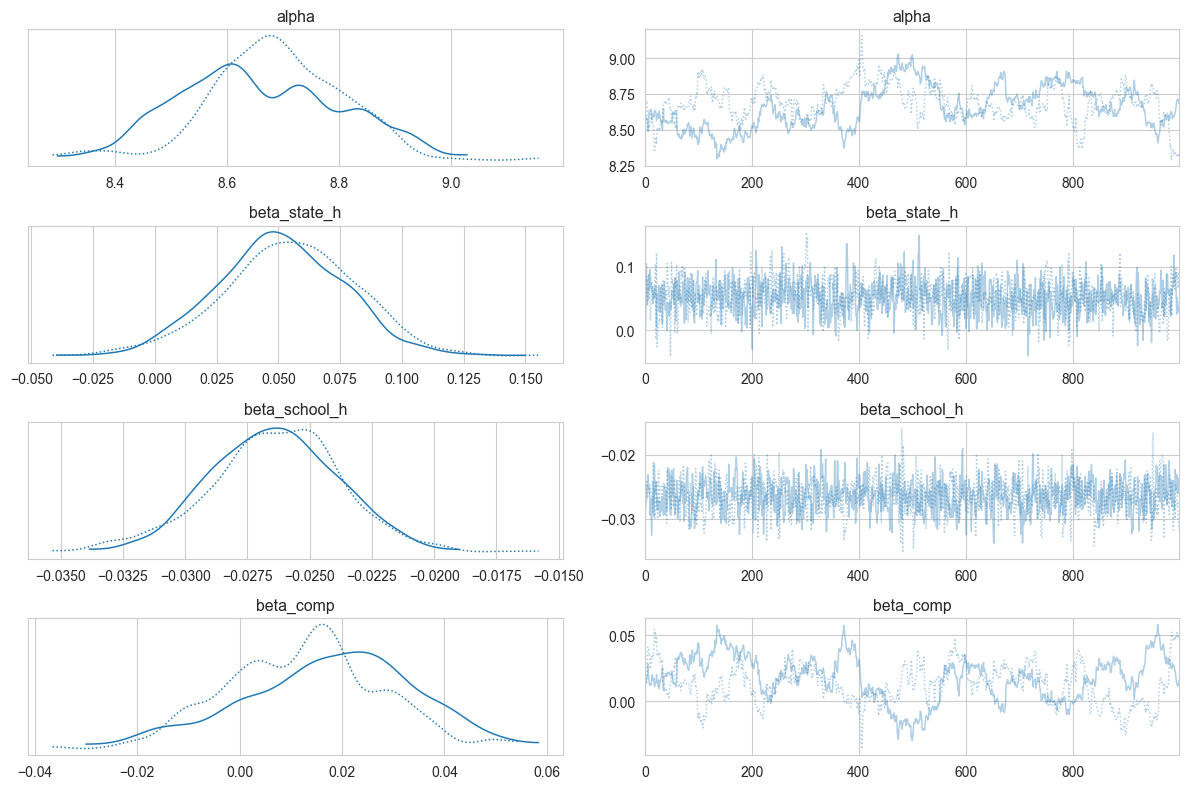

In [7]:
# Trace plots
az.plot_trace(
    idata,
    var_names=["alpha", "beta_state_h", "beta_school_h", "beta_comp"],
    compact=True
)
plt.tight_layout()
plt.show()

## 5. Counterfactual Baseline Prediction

We now calculate the "Baseline Sales". Since our model was trained *without* promo variables, the posterior predictive check essentially generates what sales *would* look like given the date, store, and environment, but implicitly assuming "average" conditions for unobserved factors.

Interpretation: "How much would we sell if we just opened the doors without any special promotions?"

In [8]:
df_baseline = bbu.baseline_posterior_predict(model, idata, df_model, return_intervals=True)
print("\n✓ Baseline predictions complete!")
df_baseline.head()

Sampling: [y_obs]


Output()

Generating posterior predictive samples...



✓ Baseline predictions complete!


,Store,Date,Sales,baseline_mean,baseline_p05,baseline_p50,baseline_p95
1016179,85,2013-01-01,4220,5795.464693,3959.495654,5638.654836,8151.587049
1014980,1,2013-01-02,5530,4329.499595,3167.875536,4263.007648,5747.269466
1014981,2,2013-01-02,4422,4398.545786,3229.033600,4325.176996,5758.017801
1014982,3,2013-01-02,6823,6114.379076,4383.248652,6007.796332,8203.900681
1014983,4,2013-01-02,9941,8672.220758,6351.462467,8515.613998,11432.141208


## 6. Empirical Lift

With the baseline in hand, we calculate **Empirical Lift**:
$$
\text{Lift} = \frac{\text{Actual Sales} - \text{Baseline}}{\text{Baseline}}
$$


In [18]:
# 1. Compute Lift
df_lift = bbu.compute_empirical_lift(df_model, df_baseline)
print("\n✓ Lift calculation complete!")

# Summary statistics
print("\n=== LIFT SUMMARY ===")
print(f"Mean empirical lift: {df_lift['lift_emp'].mean():.3f}")
print(f"Median empirical lift: {df_lift['lift_emp'].median():.3f}")
print(f"95th percentile lift: {df_lift['lift_emp'].quantile(0.95):.3f}")

# Lift by promo status
print("\n=== LIFT BY PROMO STATUS ===")
print(df_lift.groupby('Promo')['lift_emp'].describe())


✓ Lift calculation complete!

=== LIFT SUMMARY ===
Mean empirical lift: 0.058
Median empirical lift: 0.000
95th percentile lift: 0.272

=== LIFT BY PROMO STATUS ===
         count      mean       std  min  25%  50%       75%       max
Promo                                                                
0      41757.0  0.066739  0.114962  0.0  0.0  0.0  0.094905  3.337516
1      33840.0  0.046513  0.081631  0.0  0.0  0.0  0.067669  2.068937


## Discount Intensity


We then construct a **Hybrid Discount Intensity** score. While we have binary `Promo` flags, they don't capture the *depth* of a discount or the varying effectiveness of catalogs (Promo2). By combining the binary flags with the observed empirical lift, we create a continuous variable `discount_intensity` that better proxies the true effective marketing pressure.


✓ Hybrid discount intensity calculated!

=== DISCOUNT INTENSITY SUMMARY ===
          di_struct        di_emp  discount_intensity
count  75597.000000  75597.000000        75597.000000
mean       0.711536      0.211716            0.511608
std        0.556381      0.374001            0.355230
min        0.000000      0.000000            0.000000
25%        0.000000      0.000000            0.300000
50%        0.500000      0.000000            0.534866
75%        1.000000      0.299149            0.900000
max        1.500000     12.249372            5.199749


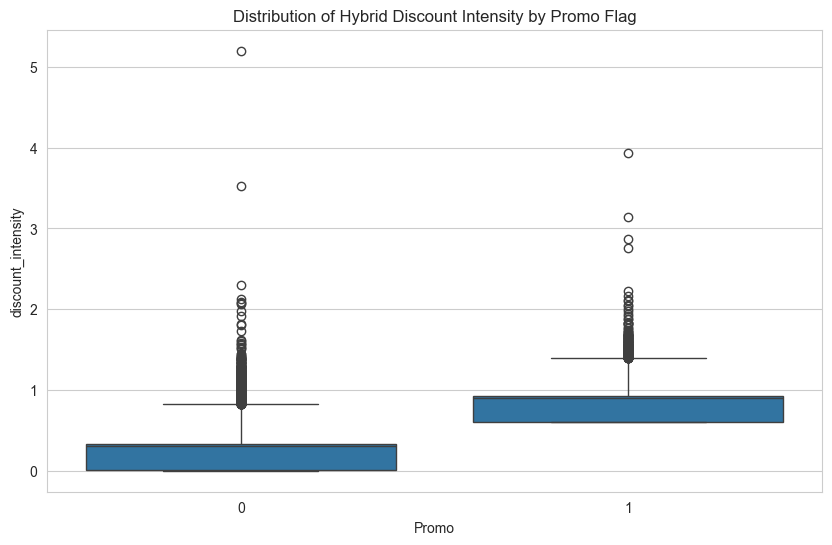

In [21]:
# 2. Compute Hybrid Discount Intensity
# We weight structural (flags) and empirical (lift) evidence
df_final = bbu.compute_hybrid_discount_intensity(df_lift, w_struct=0.6, w_emp=0.4)
print("\n✓ Hybrid discount intensity calculated!")

print("\n=== DISCOUNT INTENSITY SUMMARY ===")
print(df_final[['di_struct', 'di_emp', 'discount_intensity']].describe())

# Visualize relationship between Flag and Intensity
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final[df_final["Sales"]>0], x="Promo", y="discount_intensity")
plt.title("Distribution of Hybrid Discount Intensity by Promo Flag")
plt.show()

## 7. Saving Results
The `df_final` dataframe now contains our enriched dataset with:
- `baseline_mean`: The Bayesian baseline sales
- `lift_emp`: Empirically observed lift
- `discount_intensity`: The engineered feature for downstream MMM

We save the model trace and metadata for future use and reproducibility.

In [24]:
df_final.to_csv("rossmann_baseline_enriched.csv", index=False)
print("Saved enriched dataset to rossmann_baseline_enriched.csv")

# Save model trace
idata.to_netcdf("trace_bayesian_baseline_31.nc")
print("✓ Model trace saved to: bayesian_baseline_trace.nc")

print("\n=== ANALYSIS COMPLETE ===")


with open("trace_bayesian_baseline_31.pkl", "wb") as f:
    cloudpickle.dump(model, f)


metadata = {
    "draws": 1000,
    "tune": 1000,
    "chains": 2,
    "target_accept": 0.9,
    "stores": int(S),
    "pymc_version": pm.__version__,
}

with open("trace_bayesian_baseline_31.json", "w") as f:
    json.dump(metadata, f, indent=2)

Saved enriched dataset to rossmann_baseline_enriched.csv
✓ Model trace saved to: bayesian_baseline_trace.nc

=== ANALYSIS COMPLETE ===


## 8. Visualizations

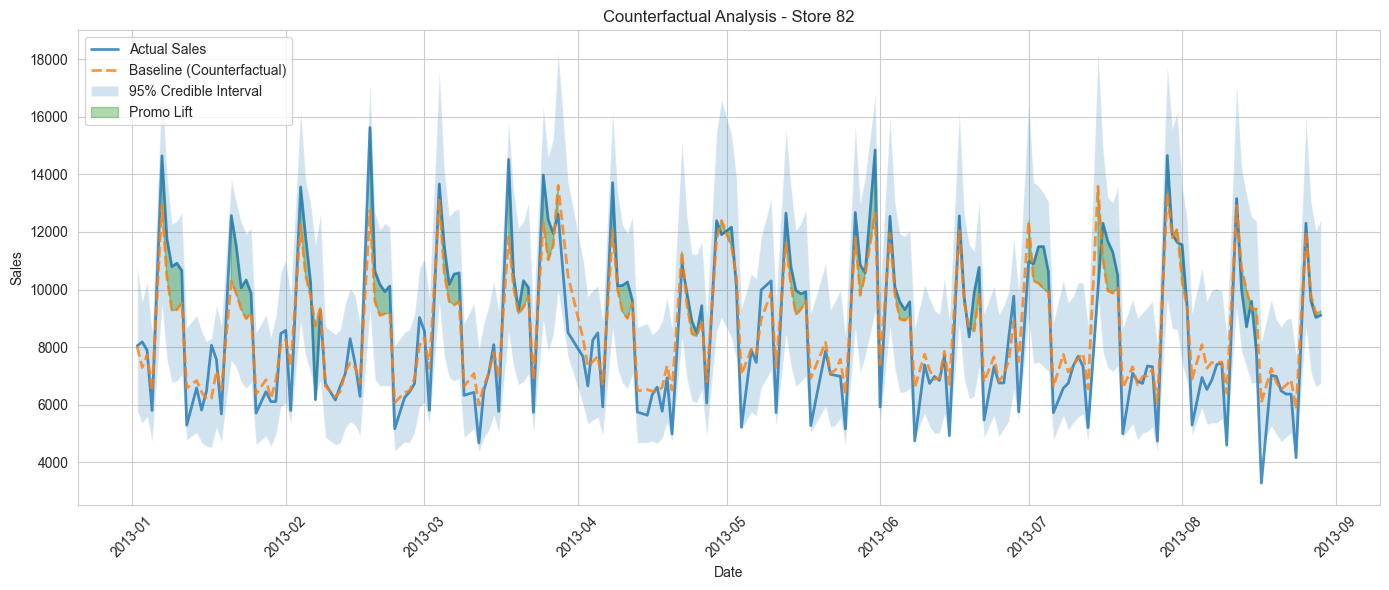

In [25]:
# Plot Actual vs Baseline for a sample store
sample_store = 82
store_data = df_final[df_final['Store'] == sample_store].sort_values('Date').head(200)

plt.figure(figsize=(14, 6))

# Plot Actual Sales vs Baseline (Counterfactual)
plt.plot(store_data['Date'], store_data['Sales'], 
         label='Actual Sales', linewidth=2, alpha=0.8)

plt.plot(store_data['Date'], store_data['baseline_mean'], 
         label='Baseline (Counterfactual)', linewidth=2, linestyle='--', alpha=0.8)

# Fill the 95% credible interval
plt.fill_between(store_data['Date'],
                 store_data['baseline_p05'],
                 store_data['baseline_p95'],
                 alpha=0.2, label='95% Credible Interval')

# Fill the Promo Lift region
plt.fill_between(store_data['Date'],
                 store_data['baseline_mean'],
                 store_data['Sales'],
                 where=store_data['Promo'] == 1,
                 alpha=0.3, label='Promo Lift', color='green')

# Labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Counterfactual Analysis - Store {sample_store}')
plt.legend()

# Rotate date labels for clarity
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


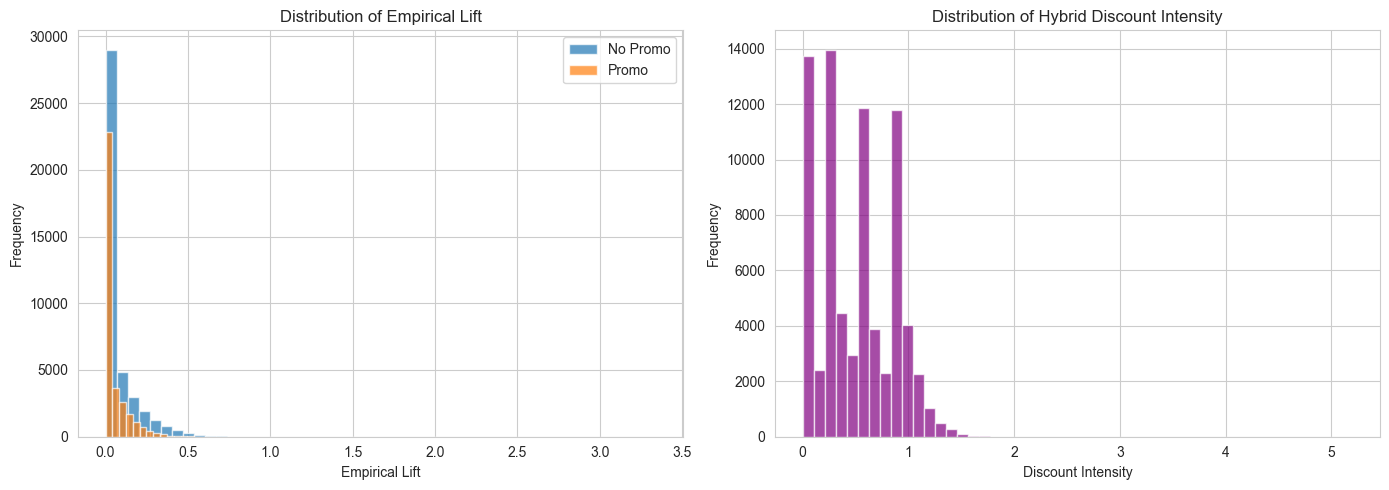

In [26]:
# Distribution of lift by promo status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lift distribution
df_final[df_final['Promo'] == 0]['lift_emp'].hist(bins=50, alpha=0.7, 
                                                    label='No Promo', ax=axes[0])
df_final[df_final['Promo'] == 1]['lift_emp'].hist(bins=50, alpha=0.7, 
                                                    label='Promo', ax=axes[0])
axes[0].set_xlabel('Empirical Lift')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Empirical Lift')
axes[0].legend()

# Discount intensity distribution
df_final['discount_intensity'].hist(bins=50, ax=axes[1], color='purple', alpha=0.7)
axes[1].set_xlabel('Discount Intensity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Hybrid Discount Intensity')

plt.tight_layout()
plt.show()